## Arewa Data Science Academy
### Deep Learning Cohort2.0
### Name: Ayodeji Akande
### Email: ayodejiakande2107@gmail.com
### Title: Week 5 Solution

# 04. PyTorch Custom Datasets Exercises

In [55]:
# Import libraries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

import os
import requests
import zipfile
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [5]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data (images from GitHub)
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak, suhsi data to {image_path}")
  zip_ref.extractall(image_path)


Did not find data/pizza_steak_sushi directory, creating...
Unzipping pizza, steak, suhsi data to data/pizza_steak_sushi


In [7]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:2])

# 2. Get random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

[PosixPath('data/pizza_steak_sushi/train/sushi/200025.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/307738.jpg')]
data/pizza_steak_sushi/test/steak/894825.jpg
steak
Random image path: data/pizza_steak_sushi/test/steak/894825.jpg
Image class: steak
Image height: 512
Image width: 512


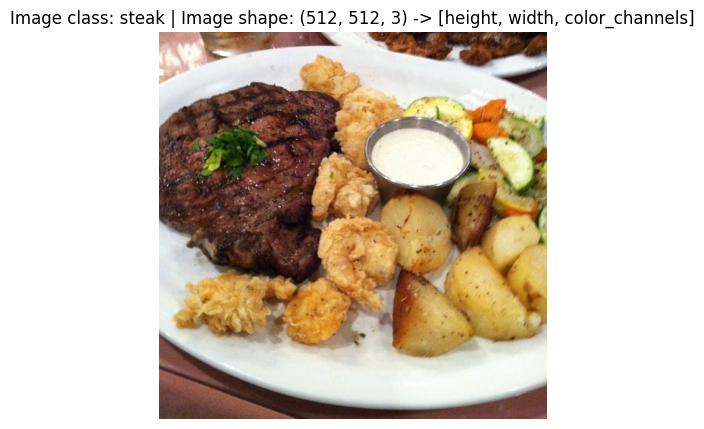

In [18]:
# visualization with matplotlib

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(5, 8))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [20]:
# transform for turning images into tensors
data_transform = transforms.Compose([
  # Resize the images to 64x64x3 (64 height, 64 width, 3 color channels)
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() # converts all pixel values from 0-255 to be between 0-1
])


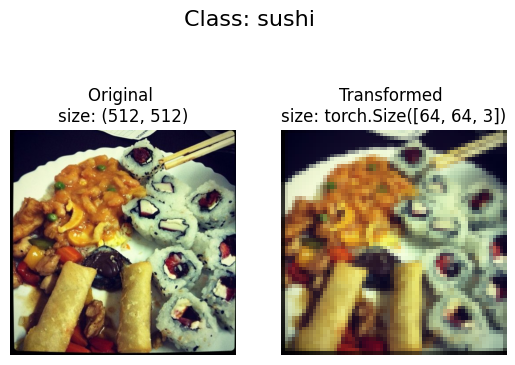

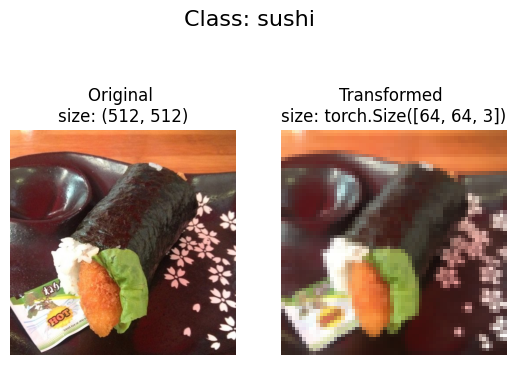

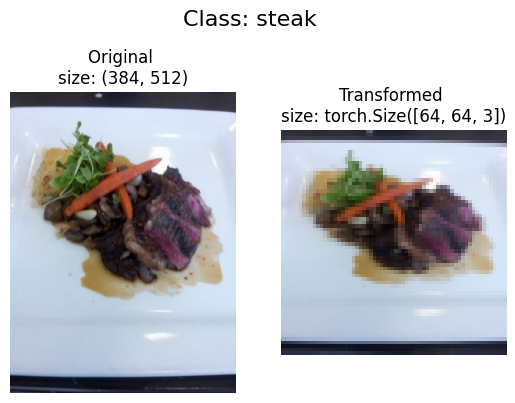

In [21]:
# Plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nsize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # permute() the image to make sure it's compatible with matplotlib
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)



### Load image data using `ImageFolder`

In [52]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 480
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 211
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [23]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [24]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [25]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [31]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dbf384ede90>,
 <torch.utils.data.dataloader.DataLoader at 0x7dbf385210d0>)

In [32]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [33]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

In [34]:
model_0 = TinyVGG(input_shape = 3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [37]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)


  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [38]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

 # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [40]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [41]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1182 | train_acc: 0.2889 | test_loss: 1.0962 | test_acc: 0.3200
Epoch: 2 | train_loss: 1.1025 | train_acc: 0.3467 | test_loss: 1.1054 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1000 | train_acc: 0.3244 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3289 | test_loss: 1.0999 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3378 | test_loss: 1.1004 | test_acc: 0.3333


In [43]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1182 | train_acc: 0.2889 | test_loss: 1.0962 | test_acc: 0.3200
Epoch: 2 | train_loss: 1.1025 | train_acc: 0.3467 | test_loss: 1.1054 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0999 | train_acc: 0.3244 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.0999 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3378 | test_loss: 1.1004 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.1000 | train_acc: 0.3600 | test_loss: 1.0991 | test_acc: 0.3200
Epoch: 7 | train_loss: 1.0987 | train_acc: 0.3244 | test_loss: 1.1042 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0772 | train_acc: 0.3733 | test_loss: 1.0502 | test_acc: 0.4133
Epoch: 9 | train_loss: 1.0219 | train_acc: 0.4800 | test_loss: 1.1193 | test_acc: 0.4133
Epoch: 10 | train_loss: 0.9129 | train_acc: 0.5778 | test_loss: 1.0754 | test_acc: 0.4400
Epoch: 11 | train_loss: 0.8897 | train_acc: 0.5956 | test_loss: 1.0306 | test_acc: 0.4800
Epoch: 12 | train_l

In [44]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1182 | train_acc: 0.2889 | test_loss: 1.0962 | test_acc: 0.3200
Epoch: 2 | train_loss: 1.1025 | train_acc: 0.3467 | test_loss: 1.1054 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1000 | train_acc: 0.3244 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3289 | test_loss: 1.0999 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3378 | test_loss: 1.1004 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.1007 | train_acc: 0.3511 | test_loss: 1.1001 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.1013 | train_acc: 0.3200 | test_loss: 1.1028 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.1172 | train_acc: 0.3289 | test_loss: 1.0915 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0755 | train_acc: 0.3867 | test_loss: 1.0469 | test_acc: 0.3467
Epoch: 10 | train_loss: 1.0144 | train_acc: 0.4800 | test_loss: 1.1679 | test_acc: 0.3067
Epoch: 11 | train_loss: 0.9973 | train_acc: 0.5156 | test_loss: 1.0342 | test_acc: 0.4267
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [45]:
# Double the number of hidden units and train for 20 epochs
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1122 | train_acc: 0.3111 | test_loss: 1.0820 | test_acc: 0.4800
Epoch: 2 | train_loss: 1.0436 | train_acc: 0.5422 | test_loss: 1.0604 | test_acc: 0.4267
Epoch: 3 | train_loss: 0.9869 | train_acc: 0.5333 | test_loss: 0.9805 | test_acc: 0.5200
Epoch: 4 | train_loss: 0.9174 | train_acc: 0.6133 | test_loss: 0.9279 | test_acc: 0.4667
Epoch: 5 | train_loss: 0.8498 | train_acc: 0.6311 | test_loss: 0.9974 | test_acc: 0.5067
Epoch: 6 | train_loss: 0.7878 | train_acc: 0.6667 | test_loss: 0.9853 | test_acc: 0.4933
Epoch: 7 | train_loss: 0.7402 | train_acc: 0.7067 | test_loss: 1.0302 | test_acc: 0.4533
Epoch: 8 | train_loss: 0.6825 | train_acc: 0.6800 | test_loss: 1.0456 | test_acc: 0.4533
Epoch: 9 | train_loss: 0.6343 | train_acc: 0.7333 | test_loss: 1.2812 | test_acc: 0.4933
Epoch: 10 | train_loss: 0.6019 | train_acc: 0.7733 | test_loss: 1.1854 | test_acc: 0.4400
Epoch: 11 | train_loss: 0.5428 | train_acc: 0.7733 | test_loss: 1.5900 | test_acc: 0.4933
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [46]:
# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi 20% data...


In [47]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 167 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 163 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 73 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 66 images in 'data/pizza_steak_sushi/test/pizza'.


Excellent, we now have double the training and testing images...

In [48]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [56]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

train_data_20_percent = ImageFolder(train_data_20_percent_path, transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path, transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, batch_size=32, num_workers=os.cpu_count(), shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

In [57]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3, hidden_units=20, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4, train_dataloader=train_dataloader_20_percent, test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1000 | train_acc: 0.3417 | test_loss: 1.0864 | test_acc: 0.3884
Epoch: 2 | train_loss: 1.0818 | train_acc: 0.3833 | test_loss: 1.0432 | test_acc: 0.4836
Epoch: 3 | train_loss: 0.9901 | train_acc: 0.5104 | test_loss: 0.9523 | test_acc: 0.5242
Epoch: 4 | train_loss: 0.8283 | train_acc: 0.6458 | test_loss: 0.9185 | test_acc: 0.5766
Epoch: 5 | train_loss: 0.8028 | train_acc: 0.6583 | test_loss: 0.9200 | test_acc: 0.5465
Epoch: 6 | train_loss: 0.7914 | train_acc: 0.6417 | test_loss: 0.9443 | test_acc: 0.5867
Epoch: 7 | train_loss: 0.7567 | train_acc: 0.6562 | test_loss: 0.9698 | test_acc: 0.5362
Epoch: 8 | train_loss: 0.7207 | train_acc: 0.6833 | test_loss: 0.9372 | test_acc: 0.5869
Epoch: 9 | train_loss: 0.6729 | train_acc: 0.7229 | test_loss: 0.9895 | test_acc: 0.5569
Epoch: 10 | train_loss: 0.6520 | train_acc: 0.7354 | test_loss: 0.9674 | test_acc: 0.5482
Epoch: 11 | train_loss: 0.6129 | train_acc: 0.7333 | test_loss: 0.9271 | test_acc: 0.5691
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [58]:
# Get a custom image
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [59]:
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

(-0.5, 3023.5, 4031.5, -0.5)

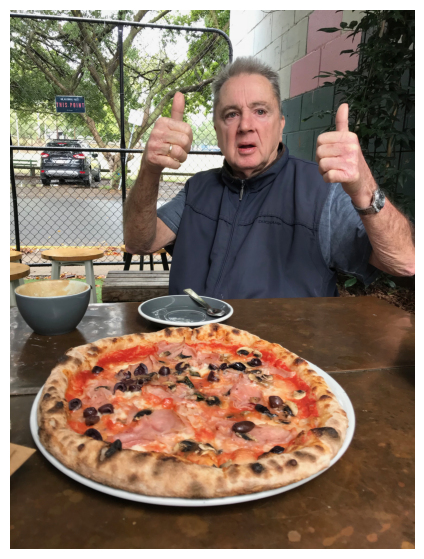

In [60]:
# View the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)

(-0.5, 63.5, 63.5, -0.5)

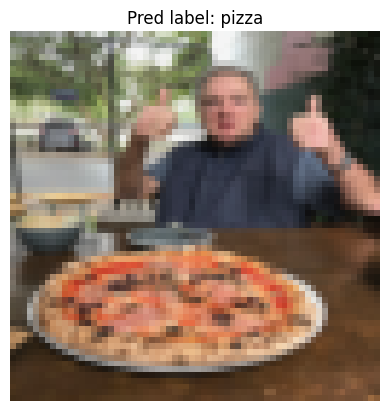

In [61]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch)

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False)